In [1]:
# Importiruyem biblioteki

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import bootstrap
from scipy.stats import shapiro
from statsmodels.stats.multitest import multipletests

In [4]:
# Saving data to dataframes
# After checking for correctness, select the required separator type when saving to checks_df and groups_df
active_studs_df = pd.read_csv('data/active_studs.csv') 
checks_df = pd.read_csv('data/checks.csv', sep = ';')
group_add_df = pd.read_csv(r'data/group_add.csv')
groups_df = pd.read_csv(r'C:\Users\Lenovo\Downloads\groups.csv', sep = ';')

In [5]:
checks_df

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [6]:
# A piece of data from the experiments arrived late, but it is valid. We'll combine it into one data frame.
groups_result_df = pd.concat([groups_df, group_add_df], ignore_index=True)

In [7]:
# Let's add information about the experiment participants' payments
# To do this, we'll first specify the field names by which we'll combine them into a single naming scheme
# Then we'll join them by ID and inner (the default).
checks_df = checks_df.rename(columns={'student_id': 'id'})
experiment_result_df = pd.merge(groups_result_df, checks_df, on='id')

In [8]:
groups_result_df

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


# Let's do a little EDA

In [9]:
experiment_result_df.head()

,id,grp,rev
0,1627,A,990.0
1,3185,B,690.0
2,25973,B,690.0
3,26280,B,690.0
4,100300,B,990.0


In [10]:
# Data Types 1
experiment_result_df.dtypes

id       int64
grp     object
rev    float64
dtype: object

In [11]:
# It's better to convert id to string
experiment_result_df['id'] = experiment_result_df['id'].astype(str)

In [12]:
# Data Types 2
experiment_result_df.dtypes

id      object
grp     object
rev    float64
dtype: object

##### A very strange result was encountered during the validation process, indicating that the subjects were logged in during the experiment. I would stop at this point and begin investigating the problem; perhaps there's a data error. Or, for example, the users were active BEFORE the experiment and made a payment, but the transaction itself was recorded DURING the experiment. In any case, the data frame needs to be cleared of suspicious IDs.

In [13]:
# Just in case, we'll check that the experiment participants were logged in during the experiment.
# We'll rename the field in active_studs_df correctly and convert it to the same data type as the id field in experiment_result_df.

active_studs_df = active_studs_df.rename(columns={'student_id': 'id'})
active_studs_df['id'] = active_studs_df['id'].astype(str)

frod_ids = experiment_result_df[~experiment_result_df['id'].isin(active_studs_df['id'])]
frod_ids_cnt = frod_ids['id'].nunique()

frod_ids_cnt

149

In [14]:
experiment_result_df['id'].nunique()

541

In [15]:
# exclude ids that have not logged into the platform and get a cleaned data frame
filtered_experiment_result_df = experiment_result_df[experiment_result_df['id'].isin(active_studs_df['id'])]

In [16]:
filtered_experiment_result_df['id'].nunique()

392

In [17]:
# Dataframe shape
filtered_experiment_result_df.shape

(392, 3)

In [18]:
# Check for empty values
filtered_experiment_result_df.isnull().sum()

id     0
grp    0
rev    0
dtype: int64

In [19]:
# Let's see how many observations there are in the control and experimental groups
filtered_experiment_result_df.groupby('grp')['id'].count()

grp
A     78
B    314
Name: id, dtype: int64

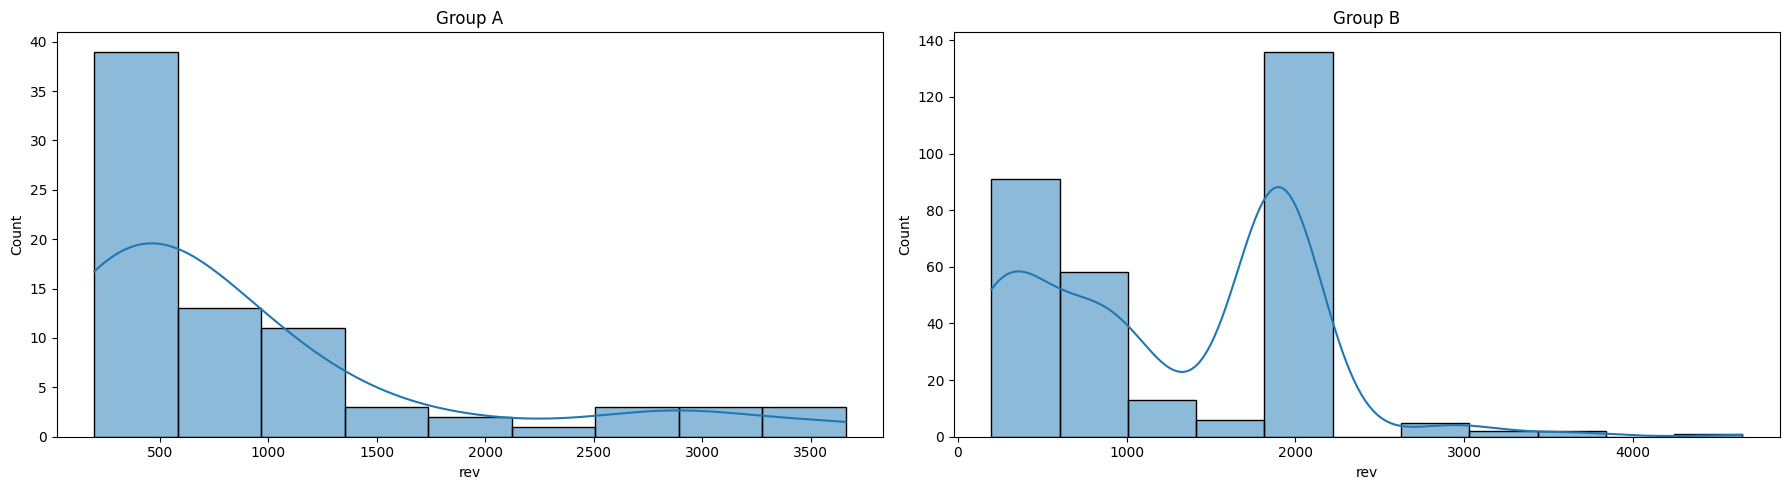

In [20]:
# Let's look at the distribution of rev by groups

df_experiment = filtered_experiment_result_df

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.histplot(df_experiment[df_experiment['grp'] == 'A']['rev'], ax=axes[0], kde=True)
axes[0].set_title('Group A')

sns.histplot(df_experiment[df_experiment['grp'] == 'B']['rev'], ax=axes[1], kde=True)
axes[1].set_title('Group B')

plt.tight_layout()
plt.show()

In [21]:
# We wonder how many users haven't paid
filtered_experiment_result_df[experiment_result_df["rev"] <= 0].count()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_14112\3929398964.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_experiment_result_df[experiment_result_df["rev"] <= 0].count()


id     0
grp    0
rev    0
dtype: int64

# Let's choose metrics

Based on the data we have, it makes sense to use ARPU as the primary metric, and since we have a heavy right tail, Median User Revenue as a secondary metric.

It would be interesting to calculate the conversion rate to successful payments, but we don't have that data. We also don't have data on the number of payments (we essentially joined users to rev, which is a unique user), so we can't calculate the average order value either.

In [22]:
# Let's calculate ARPU and Median by groups

arpu_median_stats = (
    filtered_experiment_result_df
    .groupby('grp', as_index=False)
    .agg(ARPU = ('rev', 'mean'), Median_Rev = ('rev', 'median'))
)

arpu_median_stats.round(2)

,grp,ARPU,Median_Rev
0,A,933.59,585.0
1,B,1257.88,1140.0


# Selection of tests

In [23]:
# Let's create ARPU arrays for groups
arpu_a = filtered_experiment_result_df.loc[filtered_experiment_result_df['grp']=='A', 'rev'].values
arpu_b = filtered_experiment_result_df.loc[filtered_experiment_result_df['grp']=='B', 'rev'].values

In [24]:
# It was already clear earlier that the distributions are not normal,
# but just in case, let's run the Shapiro-Wilk test
for arr, label in [(arpu_a, 'A'), (arpu_b, 'B')]:
    W, p = shapiro(arr)
    print(f"{label}: W={W:.3f}, p={p:.3f}")

A: W=0.735, p=0.000
B: W=0.855, p=0.000


Based on the Shapiro–Wilk test and the shapes of the revenue histograms by group, our distribution departs markedly from normality. Typically, t-tests for ARPU (the mean) require either a sufficiently large sample (we have only 78 observations in group A) or an approximately normal distribution. We also have unequal sample sizes and differing distribution shapes, so nonparametric options like the Mann–Whitney test and even permutation tests for the median are compromised. Log-transforming the data to achieve normality makes later interpretation difficult.

Bootstrap is suitable here because it does not require normality, handles groups with different sample sizes, and does not assume identical distribution shapes. Using bootstrap we can obtain confidence intervals. We will assess statistical significance via p-values after applying the Holm–Bonferroni correction to control for multiple comparisons (we're running two bootstrap-based tests on the same data). The p-value itself will be computed with a permutation test.

Hypotheses for the permutation test:
- **H0:** The revenue distributions in groups A and B are identical - group assignment does not affect the mean/median.  
- **H1:** The revenue distributions in groups A and B differ - group B has systematically higher mean/median.

Implicit hypotheses for the bootstrap:
- **H0:** The true difference in means (or medians) between B and A equals zero.  
- **H1:** The true difference in means (or medians) between B and A is not zero.

# Conducting tests

In [25]:
# Permutation test for p-value

# Let’s define a function that takes two samples, a test statistic, and the number of resamples
def permutation_p_value(data1, data2, statistic_func, n_resamples=10_000):
    observed_stat = statistic_func(data1, data2)  
    # compute the observed value of the statistic on the original samples
    
    combined = np.concatenate([data1, data2])  
    # to shuffle labels, we combine both samples into a single array
    
    count = 0  
    # counter for extreme permutations

    # Main loop: shuffle labels and compute the statistic at each iteration
    for _ in range(n_resamples):
        np.random.shuffle(combined)  
        # randomly shuffle the combined array
        
        sample1 = combined[:len(data1)]  
        sample2 = combined[len(data1):]  
        # split back into two pseudo-groups:
        # first len(data1) elements → pseudo-control
        # remaining elements → pseudo-treatment
        
        perm_stat = statistic_func(sample1, sample2)  
        # compute the statistic on the shuffled samples

        # if the permuted statistic is at least as extreme as the observed one,
        # count it as an extreme case (two-sided test)
        if abs(perm_stat) >= abs(observed_stat):
            count += 1

    # p-value = proportion of extreme permutations
    return count / n_resamples

In [26]:
# Bootstrap for ARPU

# Statistic function for bootstrap.
# It returns the ARPU difference between groups.
# The inputs are revenue arrays for both groups and the axis along which ARPU is calculated.
# The axis parameter is required because with vectorized=True,
# a and b will have shape (n_resamples, sample_size).
# In that case, we compute the mean across each resample.
def stat_mean(a, b, axis=0):
    return np.mean(b, axis=axis) - np.mean(a, axis=axis)
    # compute np.mean(b) and np.mean(a) along the specified axis
    # and return their difference (B − A)

# Run bootstrap to estimate the confidence interval
res_mean = bootstrap(
    data=(arpu_a, arpu_b),   # tuple of ARPU arrays for both groups
    statistic=stat_mean,     # statistic function defined above
    paired=False,            # samples are independent (different users in each group)
    vectorized=True,         # enable vectorized resampling
    confidence_level=0.95,   # confidence level
    n_resamples=10_000,      # number of resamples (10_000 == 10000; underscore improves readability)
    method='percentile'      # use 2.5th and 97.5th percentiles
)

# Compute the observed mean difference on the original data (no resampling)
mean_diff_value = stat_mean(arpu_a, arpu_b)

print(f"ARPU difference (B–A): {mean_diff_value:.2f}")

# Extract confidence interval bounds from the bootstrap result
print(f"95% CI: [{res_mean.confidence_interval.low:.2f}, {res_mean.confidence_interval.high:.2f}]")

ARPU difference (B–A): 324.29
95% CI: [90.06, 528.85]


In [27]:
# Permutation test for p-value for ARPU
p_val_arpu = permutation_p_value(arpu_a, arpu_b, stat_mean, n_resamples=10_000)
print(f"p-value для ARPU: {p_val_arpu:.4f}")

p-value для ARPU: 0.0023


In [28]:
# Bootstrap for medians
# Almost the same as for ARPU, only the function is different here 

def stat_median(a, b, axis=0):
    return np.median(b, axis=axis) - np.median(a, axis=axis)

res_median = bootstrap(
    data=(arpu_a, arpu_b),
    statistic=stat_median,
    paired=False,
    vectorized=True,
    confidence_level=0.95,
    n_resamples=10_000,
    method='percentile'
)

median_diff_value = stat_median(arpu_a, arpu_b)
print(f"Difference of medians (B–A): {median_diff_value:.2f}")
print(f"95% CI for the median: [{res_median.confidence_interval.low:.2f}, {res_median.confidence_interval.high:.2f}]")

Difference of medians (B–A): 555.00
95% CI for the median: [300.00, 1320.00]


In [30]:
# Permutation test for p-value for medians
p_val_median = permutation_p_value(arpu_a, arpu_b, stat_median, n_resamples=10_000)
print(f"p-value for median: {p_val_median:.4f}")

p-value for median: 0.0371


In [31]:
# Holm–Bonferroni correction

p_values = [p_val_arpu, p_val_median]  
# collect the original p-values into a list

# multipletests returns a tuple of 4 elements:
# 1) reject — boolean array (True means reject H0)
# 2) pvals_corrected — array of adjusted p-values
# 3) corrected alpha (not used here)
# 4) additional info (not used here)
# we unpack all elements to avoid errors
reject, pvals_corrected, _, _ = multipletests(
    p_values,
    alpha=0.05,
    method='holm'
)

print(f"ARPU: {'Reject H0' if reject[0] else 'Fail to reject H0'}, p={pvals_corrected[0]:.4f}")
print(f"Median: {'Reject H0' if reject[1] else 'Fail to reject H0'}, p={pvals_corrected[1]:.4f}")

ARPU: Reject H0, p=0.0046
Median: Reject H0, p=0.0371


# Conclusion

The new payment mechanism demonstrates both statistically significant and strong economic growth in user revenue.

Average revenue (ARPU) increased by 324 RUB (+34.7%), while median revenue increased by 555 RUB (+94.9%). The difference between the mean and the median is typical for right-skewed distributions and suggests that the feature positively affects both the “average” user and higher-spending users, driving stable and broad-based revenue growth across the entire customer base.